##SARIMA:

The SARIMA(p,d,q)(P,D,Q)m model expands on the ARIMA(p,d,q) model from the previous chapter by adding seasonal parameters.You’ll notice four new parameters in the
model: P, D, Q, and m. The first three have the same meaning as in the ARIMA(p,d,q)
model, but they are their seasonal counterparts.

The parameter m stands for the frequency. In the context of a time series, the frequency is defined as the number of observations per cycle.
Let’s consider an example where m = 12. If P = 2, this means that we are including two
past values of the series at a lag that is a multiple of m. Therefore, we’ll include the values at yt –12 and yt –24.

 Similarly, if D = 1, this means that a seasonal difference makes the series stationary.
In this case, a seasonal difference would be expressed as equatition below:

 y't
 = yt
 – yt –12

 In a situation where Q = 2, we’ll include past error terms at lags that are a multiple of
m. Therefore, we’ll include the errors ϵt –12 and ϵt –24

###Ways to identify seasonality:

1.See to plot!

2.Time Series Decomposition

Time series decomposition is a statistical task that separates the time series into its
three main components: a trend component, a seasonal component, and the residuals.
The trend component represents the long-term change in the time series. This component is responsible for time series that increase or decrease over time. The seasonal component is the periodic pattern in the time series. It represents repeated
fluctuations that occur over a fixed period of time. Finally, the residuals, or the noise,
express any irregularity that cannot be explained by the trend or the seasonal component.



In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

###Import Data

In [3]:
df = pd.read_csv('/content/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


###Decomposition

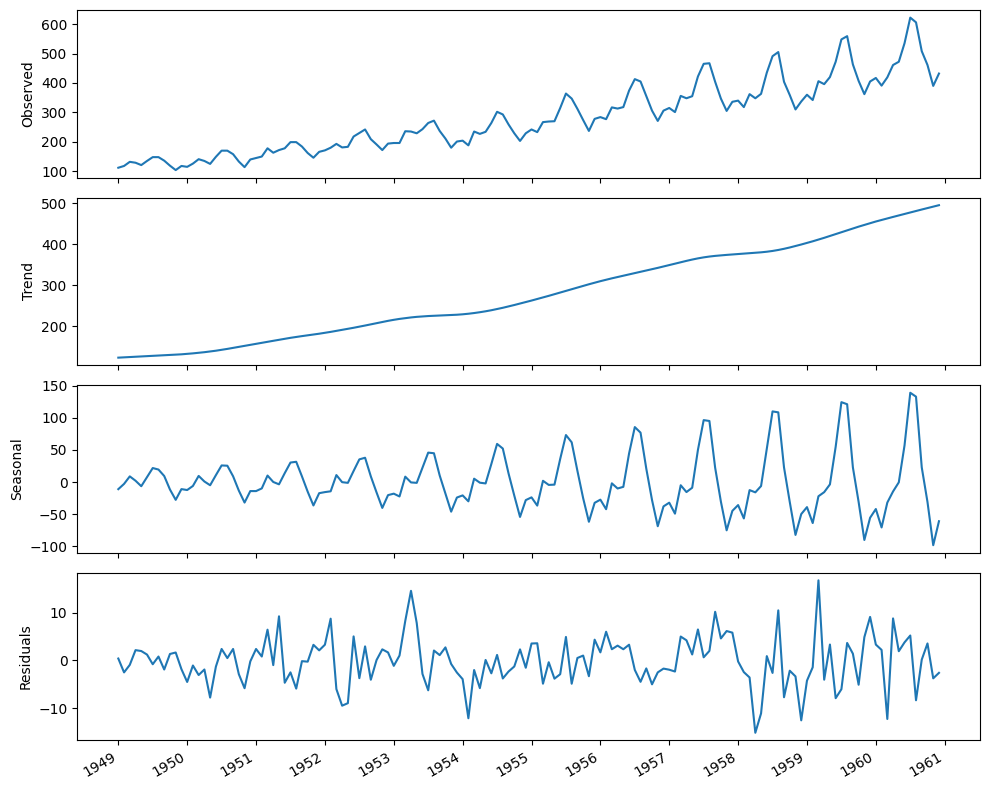

In [4]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

 In fact, there are no statistical tests to identify seasonality in time series.


Here is the updated version of our guidline:

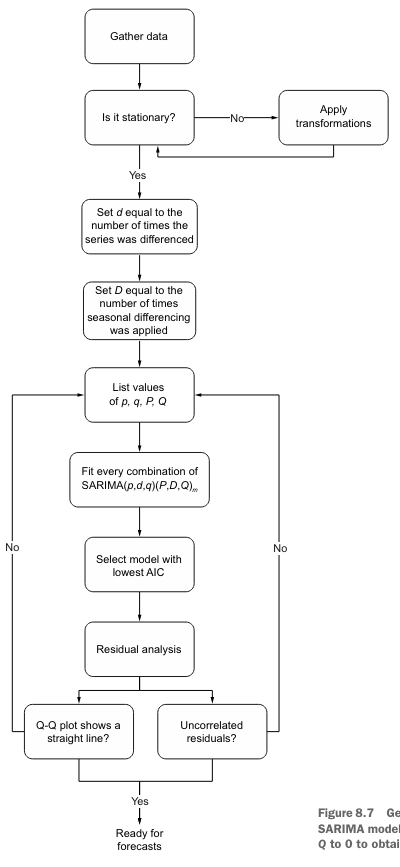

Now we compare ARIMA and SARIMA here:

###ARIMA

Check for stationarity:

In [6]:
ad_fuller_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


First order Transformation:

In [7]:
df_diff = np.diff(df['Passengers'], n=1)
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


Second order Transformation:

In [8]:
df_diff2 = np.diff(df_diff, n=1)
ad_fuller_result = adfuller(df_diff2)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29


so d=2. Now we set different values for p and q. P and Q however should considered zero.

In [11]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]
d = 2
D = 0
s = 12 #s is m or the frequency we talked before
ARIMA_order_list = list(product(ps, qs, Ps, Qs))

select best SARIMA model:

In [9]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d:
                    int, D: int, s: int) -> pd.DataFrame:

  results = []

  for order in tqdm_notebook(order_list):
    try:
      model = SARIMAX(
      endog,
      order=(order[0], d, order[1]),
      seasonal_order=(order[2], D, order[3], s),
      simple_differencing=False).fit(disp=False)
    except:
      continue
    aic = model.aic
    results.append([order, aic])
  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q,P,Q)', 'AIC']

  #Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by='AIC',
                                    ascending=True).reset_index(drop=True)

  return result_df

Train-Test split:

In [12]:
train = df['Passengers'][:-12]
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.842652
1,"(11, 4, 0, 0)",1019.034751
2,"(11, 5, 0, 0)",1020.379289
3,"(11, 1, 0, 0)",1021.025922
4,"(12, 0, 0, 0)",1021.169865
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


SARIMA(11,2,3)(0,0,0)12 = ARIMA(11,2,3)

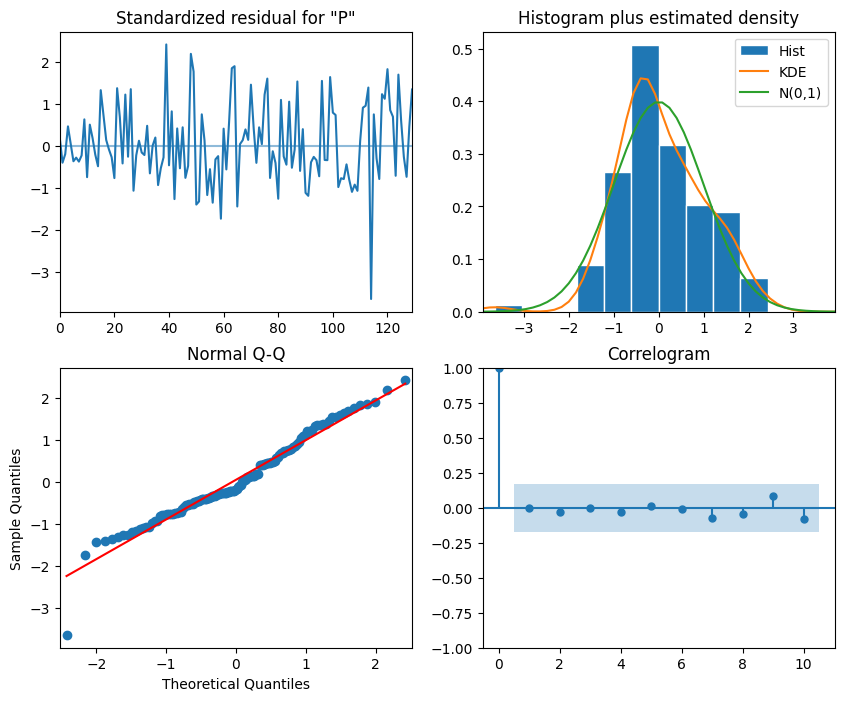

In [13]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Errors are considered white noise:

Ljung-Box test:

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = ARIMA_model_fit.resid
ljun_df = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
print(ljun_df)

      lb_stat  lb_pvalue
1    6.539124   0.010553
2    6.667840   0.035653
3    6.943387   0.073724
4    7.736593   0.101718
5    8.377928   0.136601
6    8.669212   0.193054
7    9.493241   0.219155
8    9.731307   0.284393
9    9.741755   0.371793
10  11.546080   0.316583


The returned p-values are all greater than 0.05 except for the first two values. This
means that, according to the Ljung-Box test, we reject the null hypothesis with a 5%
chance of being wrong, since we set our significance boundary to 0.05. However, the
third value and onwards are all greater than 0.05, so we reject the null hypothesis, concluding that the residuals are uncorrelated starting at lag 3.

This is an interesting situation to dissect, because the graphical analysis of the
residuals leads us to conclude that they resemble white noise, but the Ljung-Box test
points to some correlation at lags 1 and 2. This means that our ARIMA model is not
capturing all the information from the data.
 In this case, we’ll move forward with the model, because we know that we are modeling seasonal data with a non-seasonal model. Therefore, the Ljung-Box test is really
telling us that our model is not perfect, but that’s okay, because part of this exercise is
to compare the performance of ARIMA and SARIMA and demonstrate that SARIMA
is the way to go when dealing with seasonal data.

In [16]:
test = df.iloc[-12:]
test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

###SARIMA:

In [17]:
ad_fuller_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


First order transformation:

In [18]:
df_diff = np.diff(df['Passengers'], n=1)
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


Seasonal transformation:

In [20]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.62486236026156
p-value: 3.823046855601547e-30


Finding best set of p, q, P, Q:

In [21]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
train = df['Passengers'][:-12]
d = 1
D = 1
s = 12
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.240189
1,"(2, 1, 1, 3)",894.110325
2,"(1, 0, 1, 2)",894.285656
3,"(0, 1, 1, 2)",894.991643
4,"(1, 0, 2, 1)",895.092629
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.603099
254,"(0, 0, 3, 0)",908.742583


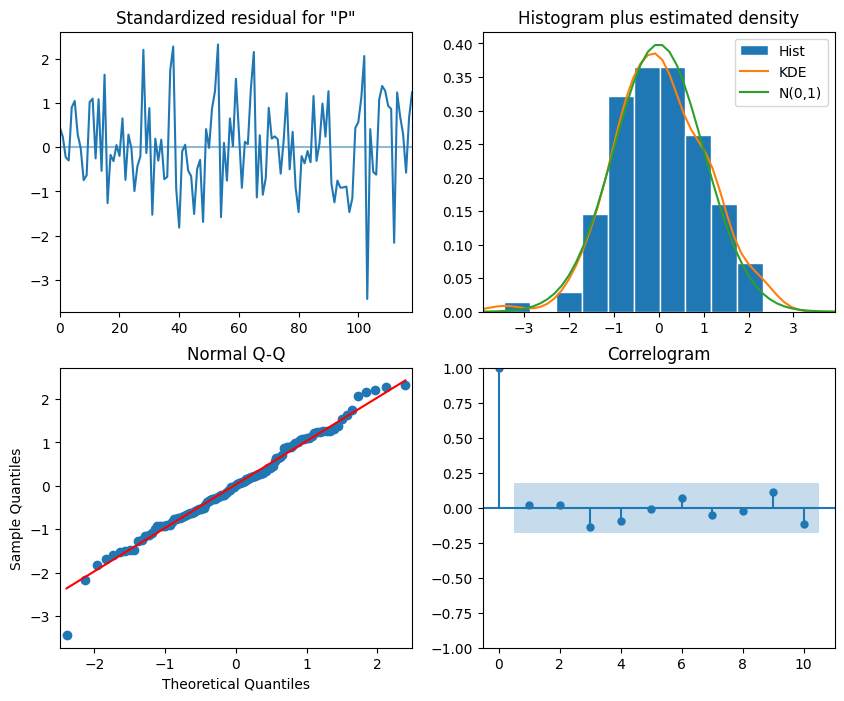

In [22]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12),
                       simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid
lb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
print(lb_df)

     lb_stat  lb_pvalue
1   0.004663   0.945557
2   0.744726   0.689104
3   1.019752   0.796473
4   1.226798   0.873667
5   1.437233   0.920197
6   1.711221   0.944252
7   2.306318   0.940962
8   2.720695   0.950645
9   2.737284   0.973807
10  4.976578   0.892737


The returned p-values are all greater than 0.05. Therefore, we do not reject the null
hypothesis, and we conclude that the residuals are independent and uncorrelated,
just like white noise.

In [24]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

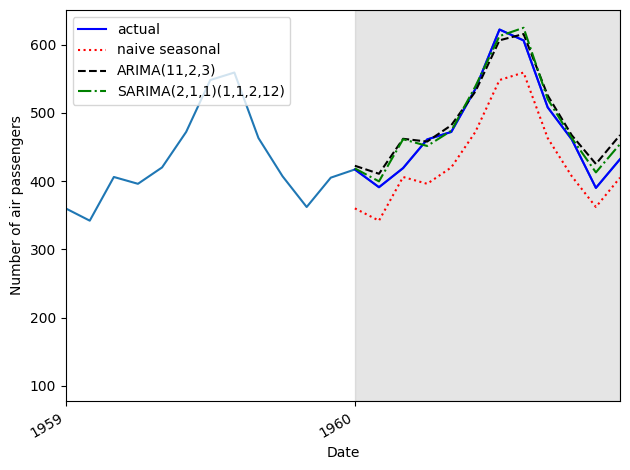

In [26]:
fig, ax = plt.subplots()
ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)
fig.autofmt_xdate()
plt.tight_layout()

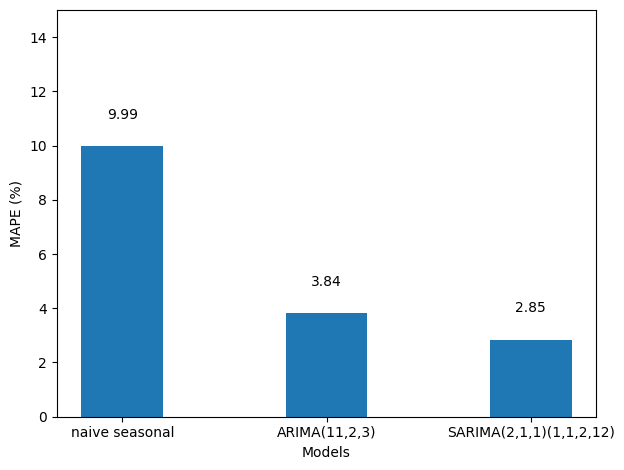

In [27]:
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])
fig, ax = plt.subplots()
x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)
for index, value in enumerate(y):
  plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
plt.tight_layout()